In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1. Ładowanie danych z titanic.csv do DataFrame**

In [162]:
import pandas as pd

titanic_data_frame = pd.read_csv('/content/drive/MyDrive/titanic.csv')

**2. Sprawdzanie rozmiaru DataFrame oraz wyświetlenie nagłówka wraz z trzema pierwszymi wierszami**

In [163]:
print("Number of rows and columns: ", titanic_data_frame.shape)
titanic_data_frame.head(3)

Number of rows and columns:  (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


**3. Wybranie zminnej, oznaczającej predykowaną klasę.**

Moim zdaniem zmienną, oznaczającą predykowaną klasę jest 'Survived'

In [195]:
target_column = titanic_data_frame['Survived']
target_column.head(5)

,Survived
0,0
1,1
2,1
3,1
4,0


**4. Istotność kolumn w kontekscie zadania**

W mojej ocenie nie wszystkie kolumny w zbiorze danych dotyczących Titanica są istotne dla trenowania modelu przewidującego, czy pasażer przeżył czy zginął.

Na przykład numer biletu jest prawie unikalny dla każdej osoby, jednak, jak pokazała moja analiza, nie wszystkie numery są wyjątkowe — występują powtórzenia. Mimo to, trudno z nich wywnioskować zależności, które pomogłyby modelowi przewidzieć wynik. Oczywiście, można rozważać nietypowe teorie, np. czy osoby z cyfrą 7 w numerze biletu miały większe szanse na przeżycie, ale nie ma to solidnych podstaw naukowych :)

Z kolei wartości w kolumnie z imieniem i nazwiskiem są w dużej mierze unikalne, co utrudnia ich grupowanie i kodowanie w formie liczbowej. Ponadto, podobnie jak numer biletu, imię i nazwisko nie dostarczają istotnej informacji prognostycznej dla modelu.

Kolumna Cabin zawiera dużą ilość brakujących danych, które trudno i nieopłacalnie uzupełniać.

Dlatego uważam, że kolumny 'Ticket', 'Name' i 'Cabin' można bezpiecznie wykluczyć z zestawu cech używanych do trenowania modelu. (Usuwanie kolumny „Cabin” jest uzasadnione i szczególnie wyjaśnione w punkcie 6.)

In [165]:
print("Number of unique values in column Ticket: ", titanic_data_frame['Ticket'].nunique())
print("Number of missing values in column Ticket: ", titanic_data_frame['Ticket'].isnull().sum())
print("Number of unique values in column Name: ", titanic_data_frame['Name'].nunique())
print("Number of missing values in column Name: ", titanic_data_frame['Name'].isnull().sum())
refined_titanic_data_frame = titanic_data_frame.drop(columns=['Name', 'Ticket'])
refined_titanic_data_frame.head(3)


Number of unique values in column Ticket:  681
Number of missing values in column Ticket:  0
Number of unique values in column Name:  891
Number of missing values in column Name:  0


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,71.2833,C85,C
2,3,1,3,female,26.0,0,0,7.9250,NaN,S


**5. Odpowiedniość typów danych do znaczenia kolumn**
Zauważyłam, że typ danych w kolumnie 'Age' jest ustawiony jako float64, który zmieniłabym na int64. Kolumny 'Sex', 'Cabin' oraz 'Embarked' mają typ object. Te kolumny przechowują dane kategorialne, które następnie zamienię na dane numeryczne

In [166]:
def fill_empty_values_with_median(df, col_name):
  df[col_name] = df[col_name].fillna(df[col_name].median())
  return df

In [167]:
refined_titanic_data_frame.info()
print("Number of missing values in column Age: ", refined_titanic_data_frame['Age'].isnull().sum())
refined_titanic_data_frame = fill_empty_values_with_median(refined_titanic_data_frame, 'Age')
refined_titanic_data_frame['Age'] = refined_titanic_data_frame['Age'].astype('int64')
refined_titanic_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         793 non-null    float64
 8   Cabin        204 non-null    object 
 9   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 69.7+ KB
Number of missing values in column Age:  177
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclas

**6. Brakujące wartości**
Brakujące wartości wytępują w kolumnach 'Fare', 'Cabin' i 'Embarked'. To widać w info w pukcie 5.

In [168]:
print("Number of missing values in column Fare: ", refined_titanic_data_frame['Fare'].isnull().sum())
print("Number of missing values in column Cabin: ", refined_titanic_data_frame['Cabin'].isnull().sum())
print("Number of missing values in column Embarked: ", refined_titanic_data_frame['Embarked'].isnull().sum())

Number of missing values in column Fare:  98
Number of missing values in column Cabin:  687
Number of missing values in column Embarked:  2


* Kolumnia Fare zawiera dane typu float64, brakujące wartości w tej kolumnie tak jak i w kolumnie Age zostały zamienione miedianą



In [169]:
refined_titanic_data_frame = fill_empty_values_with_median(refined_titanic_data_frame, 'Fare')
print("Number of missing values in column Fare: ", refined_titanic_data_frame['Fare'].isnull().sum())

Number of missing values in column Fare:  0


* Kolumna Embarked zawiera dane kategorialne, które mogą przyjmować wartości takie jak: S, C, Q i są 2 wartości puste.

In [170]:
print("Number of unique values in column Embarked: ", refined_titanic_data_frame['Embarked'].nunique())
print("Number of unique values in column Embarked: ", refined_titanic_data_frame['Embarked'].unique())

Number of unique values in column Embarked:  3
Number of unique values in column Embarked:  ['S' 'C' 'Q' nan]


Te dwie brakujące wartości zamieniłam najczęstszą wartością(modą)

In [171]:
def fill_empty_values_with_moda(df, col_name):
  moda = df[col_name].mode()[0]
  df[col_name] = df[col_name].fillna(moda)
  return df

In [172]:
refined_titanic_data_frame = fill_empty_values_with_moda(refined_titanic_data_frame, 'Embarked')
print("Number of missing values in column Embarked: ", refined_titanic_data_frame['Embarked'].isnull().sum())

Number of missing values in column Embarked:  0


* W kolumnie Cabin 75 % komórek zawierają brakujące odpowiedzi. Pozostałe komórki zawierają dane, które słabo się powtarzają. Z powodu tych dwóch przyczyn i tego faktu, że podana kolumna zawiera dane kategorialne, które trudno zastąpić ta kolumna nie wniesie istotnej wartości do procesu uczenia modelu.

In [173]:
print("Number of unique values in column Cabin: ", refined_titanic_data_frame['Cabin'].nunique())
print("Number of unique values in column Cabin: ", refined_titanic_data_frame['Cabin'].unique())

Number of unique values in column Cabin:  147
Number of unique values in column Cabin:  [nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 

In [174]:
refined_titanic_data_frame = refined_titanic_data_frame.drop(columns=['Cabin'])
refined_titanic_data_frame.head(3)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22,1,0,7.2500,S
1,2,1,1,female,38,1,0,71.2833,C
2,3,1,3,female,26,0,0,7.9250,S


In [175]:
refined_titanic_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    int64  
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    object 
dtypes: float64(1), int64(6), object(2)
memory usage: 62.8+ KB


Na tym etapie już nie ma brakujących wartości

**7. Dodawanie 2 dodatkowych kolumn**

* Pierwsza dodatkowa kolumna to RelNum (cakowita liczba krewnych na pokadzie)

* Druga dodatkowa kolumna to AgeCat (kategoria wiekowa)

In [176]:
refined_titanic_data_frame['RelNum'] = refined_titanic_data_frame['SibSp'] + refined_titanic_data_frame['Parch']
refined_titanic_data_frame.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,RelNum
0,1,0,3,male,22,1,0,7.2500,S,1
1,2,1,1,female,38,1,0,71.2833,C,1
2,3,1,3,female,26,0,0,7.9250,S,0


In [177]:
def define_a_group(age):
  if age <= 1:
    return 'Infant'
  elif age <= 12:
    return 'Child'
  elif age <= 19:
    return 'Teen'
  elif age <= 35:
    return 'Adult'
  elif age <= 60:
    return 'Middle_Aged'
  else:
    return 'Senior'

groups = []
for age in refined_titanic_data_frame['Age']:
  groups.append(define_a_group(age))

refined_titanic_data_frame['AgeCat'] = groups
refined_titanic_data_frame.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,RelNum,AgeCat
0,1,0,3,male,22,1,0,7.2500,S,1,Adult
1,2,1,1,female,38,1,0,71.2833,C,1,Middle_Aged
2,3,1,3,female,26,0,0,7.9250,S,0,Adult


**8. Destrybucje danych**

In [178]:
import matplotlib.pyplot as plt
import seaborn as sns

* Dla danych numerycznych

In [179]:
def num_histogramm(df, col_name):
  data = df[col_name]
  mean_val = data.mean()
  median_val = data.median()

  plt.figure(figsize=(6, 4))
  plt.hist(data, bins=30, color='steelblue', edgecolor='black')
  plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
  plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')

  plt.title(f'Distribution of {col_name}')
  plt.xlabel(col_name)
  plt.ylabel('Frequency')
  plt.legend()
  plt.tight_layout()
  plt.show()

Dla kolumny Age

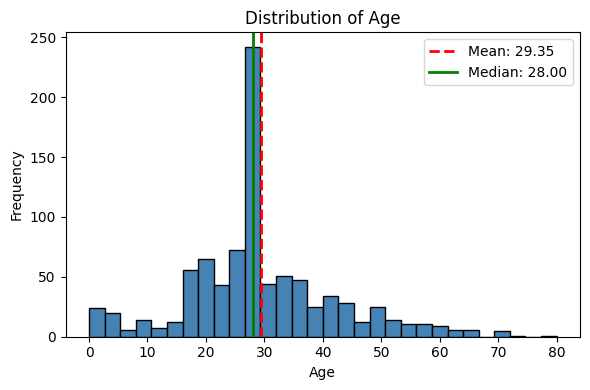

In [180]:
num_histogramm(refined_titanic_data_frame, 'Age')

Zmienna Age jest dystrybuowana mniej wiécej normalnie

Dla kolumny Fare

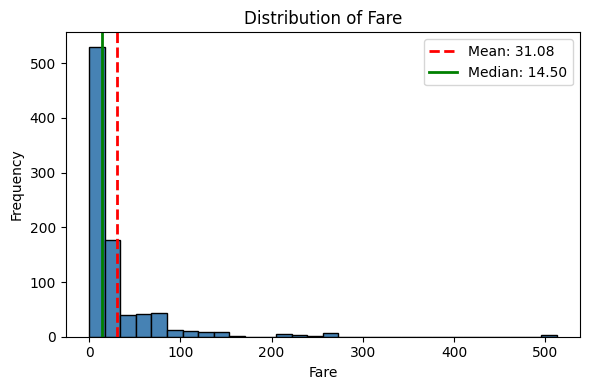

In [181]:
num_histogramm(refined_titanic_data_frame, 'Fare')

Zmienna Fare jest dystrybuowana asymetrycznie

Dla kolumny Pclass

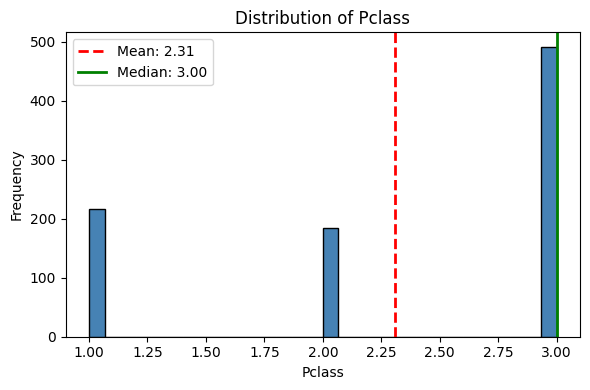

In [182]:
num_histogramm(refined_titanic_data_frame, 'Pclass')

Zmienna Pclass jest dystrybuowana asymetrycznie

* Dla zmiennych kategorialnych

In [183]:
def kat_histogramm(df, col_name):
  counts = df[col_name].value_counts()
  plt.figure(figsize=(6, 4))
  counts.plot(kind='bar', color='steelblue', edgecolor='black')
  plt.title(f'Distribution of {col_name}')
  plt.xlabel(col_name)
  plt.ylabel('Count')
  plt.xticks(rotation=0)
  plt.show()

Dla kolumny Sex

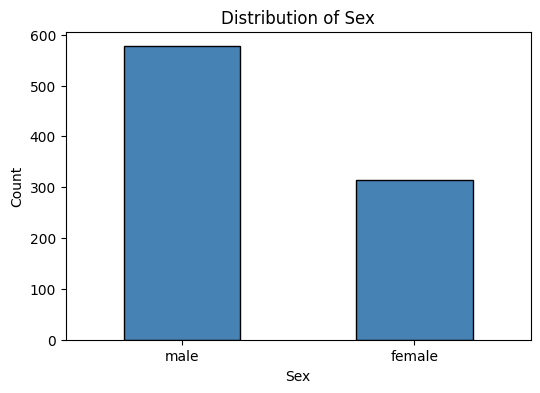

In [184]:
kat_histogramm(refined_titanic_data_frame, 'Sex')

Dominuje kategoria 'male'

Dla kolumny Embarked

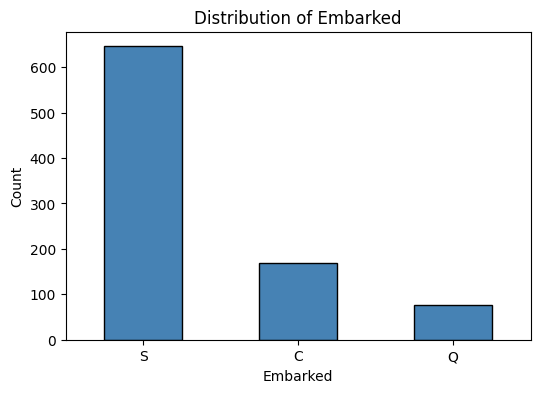

In [185]:
kat_histogramm(refined_titanic_data_frame, 'Embarked')

Dominuje kategoria 'S'

Dla kolumny AgeCat

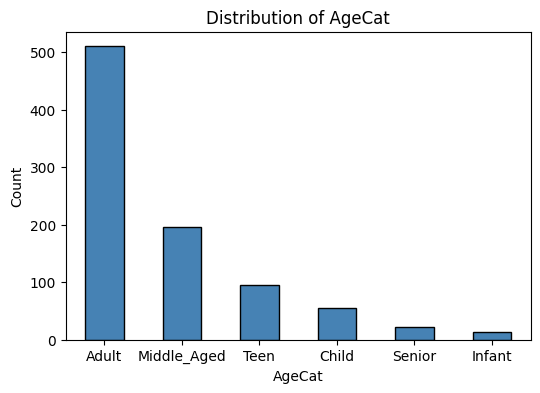

In [187]:
kat_histogramm(refined_titanic_data_frame, 'AgeCat')

Dominuje kategoria 'Adult'

**9. Wartości skrajne**

Wykresн boxplot w celu identyfikacji wartości skrajnych został wykonany dla bardziej informacyjnych kolumn, zawierających dane numeryczne

In [188]:
def boxplot(df, col_name):
  plt.figure(figsize=(6, 4))
  sns.boxplot(x=df[col_name], color='lightgreen') #
  plt.title(f'Distribution of {col_name} (boxplot)')
  plt.xlabel(col_name)
  plt.show()

Dla kolumny Age

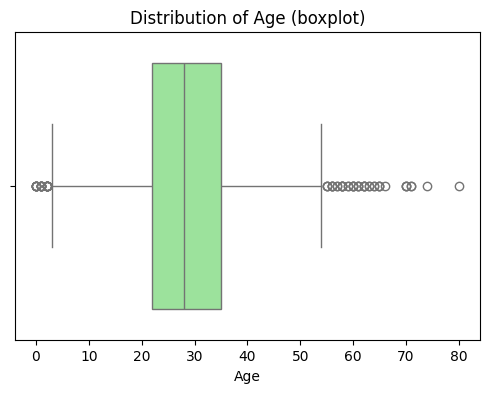

In [189]:
boxplot(refined_titanic_data_frame, 'Age')

Są wartości skrajne. Istnieje wartość, która znacząco odbiega od pozostałych i być może w dalszej analizie będzie wymagała zastąpienia. Ale ta skrajnia wartość nie zaprzecza rzeczywistości.

Dla kolumny Fare

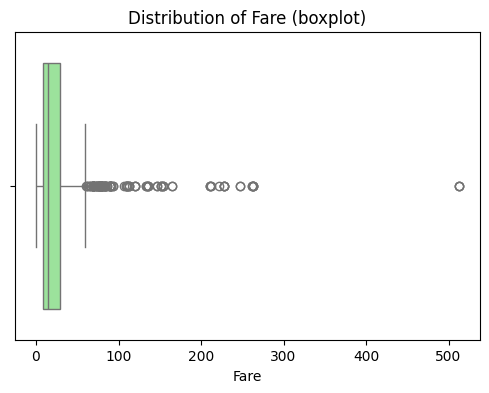

In [190]:
boxplot(refined_titanic_data_frame, 'Fare')

Są wartości skrajne. Istnieje wartość, która znacząco odbiega od pozostałych i być może w dalszej analizie będzie wymagała zastąpienia

Dla kolumny RelNum

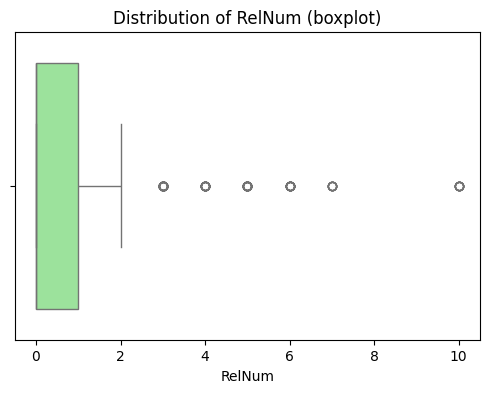

In [191]:
boxplot(refined_titanic_data_frame, 'RelNum')

Są wartości skrajnie, ale są istotne. Bo w rzeczywistości takie dany mogłyby być

Dla kolumny Parch

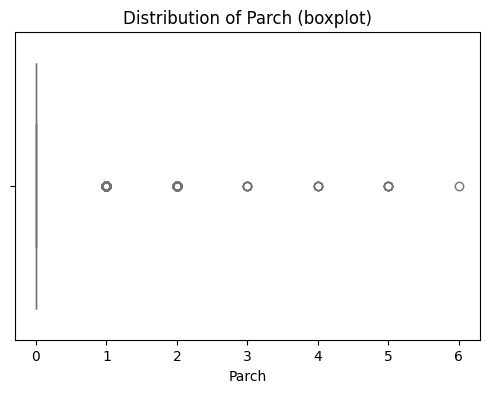

In [192]:
boxplot(refined_titanic_data_frame, 'Parch')

Są wartości skrajnie, ale są istotne. Bo w rzeczywistości takie dany mogłyby być

Dla kolumny SibSp

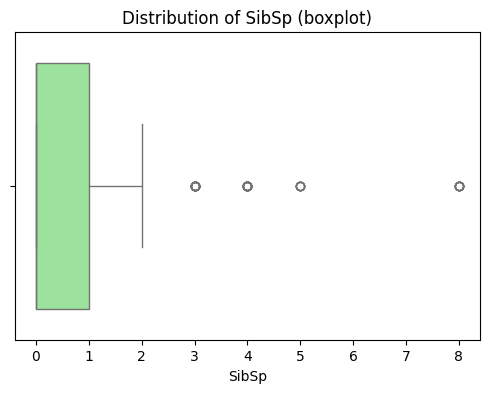

In [193]:
boxplot(refined_titanic_data_frame, 'SibSp')

Są wartości skrajnie, ale są istotne. Bo w rzeczywistości takie dany mogłyby być

**10. Rozkład zmiennej predykowanej względem zmiennych kategorialnych i numeryczntch**

Rozkład zmiennej Survived względem najbardziej informacyjnych zmiennych numerycznych

In [206]:
def target_vs_numeric(df, target_column, col_name):
  plt.figure(figsize=(6, 4))
  sns.boxplot(x=target_column, y=col_name, data=df,hue=target_column, palette='pastel')
  plt.title(f'{target_column} vs {col_name}')
  plt.xlabel(target_column)
  plt.ylabel(col_name)
  plt.tight_layout()
  plt.show()

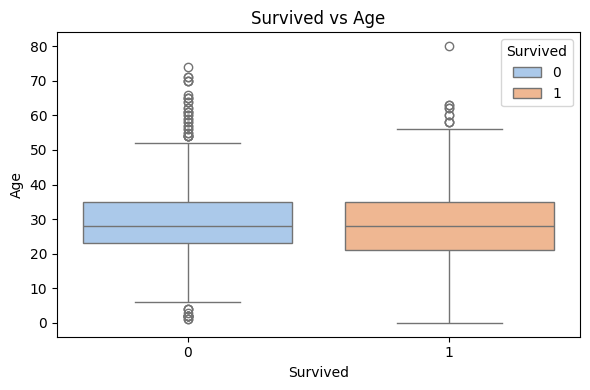

In [207]:
target_vs_numeric(refined_titanic_data_frame, target_column, 'Age')

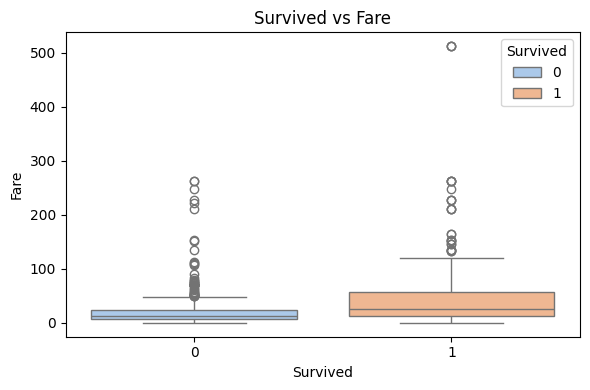

In [208]:
target_vs_numeric(refined_titanic_data_frame, target_column, 'Fare')

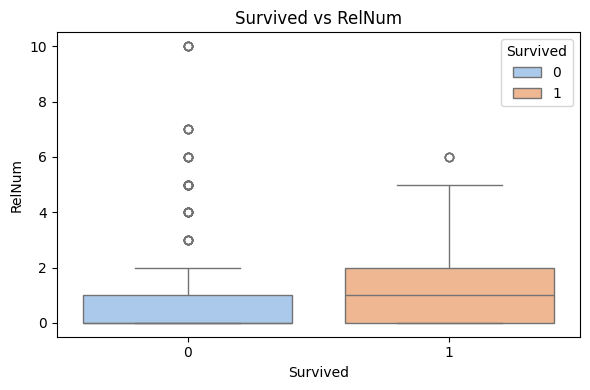

In [209]:
target_vs_numeric(refined_titanic_data_frame, target_column, 'RelNum')

Rozkład zmiennej Survived względem najbardziej informacyjnych zmiennych numerycznych

In [210]:
def target_vs_kat(df, target_column, col_name):
  plt.figure(figsize=(6, 4))
  sns.countplot(x=col_name, hue=target_column, data=df, palette='pastel')
  plt.title(f'{target_column} vs {col_name}')
  plt.xlabel(col_name)
  plt.ylabel('Number of observations')
  plt.tight_layout()
  plt.show()

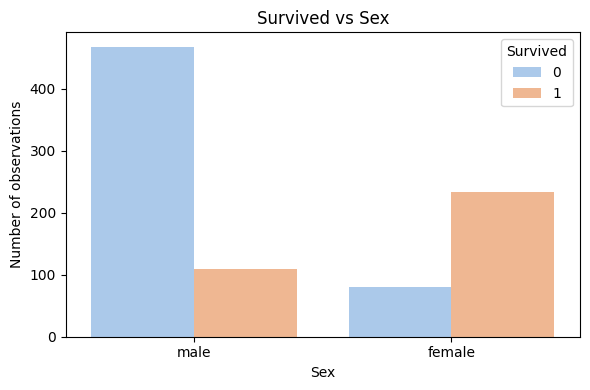

In [211]:
target_vs_kat(refined_titanic_data_frame, target_column, 'Sex')

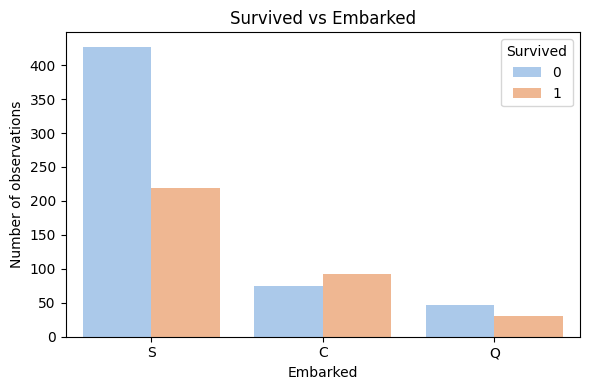

In [212]:
target_vs_kat(refined_titanic_data_frame, target_column, 'Embarked')

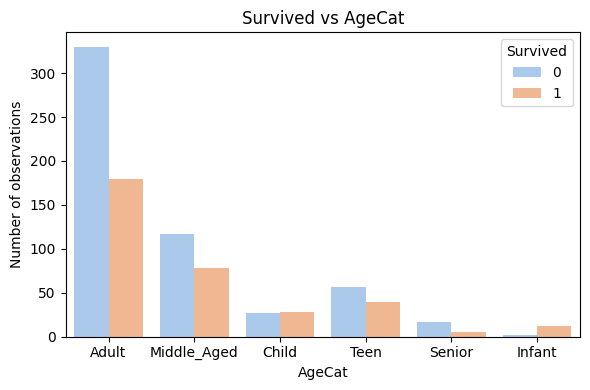

In [213]:
target_vs_kat(refined_titanic_data_frame, target_column, 'AgeCat')

**11. Kodowanie cech kategorialnych**


* Kolumna 'Sex'

  Tą kolumnę postanowiłam zakodować za pomocą metody Binary encoding, ponieważ w tej kolumnie mamy tylko 2 kategorie: male i female

In [152]:
print("Number of unique values in column Sex: ", refined_titanic_data_frame['Sex'].nunique())
print("Unique values in column Sex: ", refined_titanic_data_frame['Sex'].unique())

Number of unique values in column Sex:  2
Unique values in column Sex:  ['male' 'female']


In [153]:
refined_titanic_data_frame['Sex'] = refined_titanic_data_frame['Sex'].map({'male': 0, 'female' : 1})
refined_titanic_data_frame.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,RelNum,AgeCat
0,1,0,3,0,22,1,0,7.2500,S,1,Adult
1,2,1,1,1,38,1,0,71.2833,C,1,Middle_Aged
2,3,1,3,1,26,0,0,7.9250,S,0,Adult


* Kolumna 'Embarked'

Tą kolumnę postanowiłam zakodować za pomocą metody Original encoding, ponieważ mamy tu tylko 3 kategorie(patrz punkt 6) i łatwo im przypisać liczby zgodnie z ich kolejnością alfabetyczną

In [154]:
mapping = {'C' : 0, 'Q' : 1, 'S' : 2}
refined_titanic_data_frame['Embarked'] = refined_titanic_data_frame['Embarked'].map(mapping)
refined_titanic_data_frame.head(3)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,RelNum,AgeCat
0,1,0,3,0,22,1,0,7.2500,2,1,Adult
1,2,1,1,1,38,1,0,71.2833,0,1,Middle_Aged
2,3,1,3,1,26,0,0,7.9250,2,0,Adult


* Kolumna AgeCat

Tą kolumnę też postanowiłam zakodować za pomocą metody Original encoding, ponieważ mamy tu tylko 6 kategorii i łatwo im przypisać liczby zgodnie z ich kolejnością alfabetyczną

In [155]:
print("Number of unique values in column AgeCat: ", refined_titanic_data_frame['AgeCat'].nunique())
print("Unique values in column AgeCat: ", refined_titanic_data_frame['AgeCat'].unique())

Number of unique values in column AgeCat:  6
Unique values in column AgeCat:  ['Adult' 'Middle_Aged' 'Child' 'Teen' 'Senior' 'Infant']


In [159]:
mapping = {'Adult' : 0, 'Middle_Aged' : 1, 'Child' : 2, 'Teen' : 3, 'Senior' : 4, 'Infant' : 5}
refined_titanic_data_frame['AgeCat'] = refined_titanic_data_frame['AgeCat'].map(mapping)
refined_titanic_data_frame.head(3)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,RelNum,AgeCat
0,1,0,3,0,22,1,0,7.2500,2,1,0
1,2,1,1,1,38,1,0,71.2833,0,1,1
2,3,1,3,1,26,0,0,7.9250,2,0,0


Dane kategorialne zostały zakodowane. Teraz DataFrame zawiera tylko dane numieryczne

In [160]:
refined_titanic_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    int64  
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    int64  
 9   RelNum       891 non-null    int64  
 10  AgeCat       891 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 76.7 KB
